In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [5]:
sys.path.append('../..')

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot

### EEZ shapes 

In [7]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [8]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

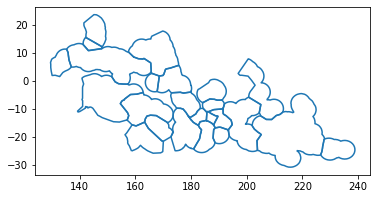

In [9]:
EEZs.boundary.plot(); 

### year and month (initial month of the forecast)

In [10]:
year = 2021

In [11]:
month = 8

### read the probabilistic forecasts from the GCMs now 

### provider 

In [12]:
provider = 'CDS'

#### list of GCMs to inlude 

In [13]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC']
# list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP']

#### period (`monthly` or `seasonal`)

In [14]:
period = 'monthly'
# period = 'seasonal'

In [15]:
if period == 'seasonal': 
    nsteps = 3
elif period == 'monthly': 
    nsteps = 5

#### quantiles (`tercile`, `decile`, `percentile`, with the latest including categories defined by quantile 0.02 (2%) and then 0.05 to 0.95 with 0.05 increment)

In [16]:
quantile = 'percentile'

### variable 

In [17]:
varname = 'precip'

### domain 

In [18]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [120, 240, -38, 22.5]}

In [19]:
domain = 'Water_Watch'

### paths to the realtime forecasts

In [20]:
dpath_forecasts = CWD.parents[1].joinpath("outputs/C3S")

In [21]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

### checks the files names 

In [22]:
[f.name for f in lfiles]

['monthly_percentiles_probabilities_from_2021-08_UKMO.netcdf',
 'monthly_percentiles_probabilities_from_2021-08_ECCC.netcdf',
 'monthly_percentiles_probabilities_from_2021-08_DWD.netcdf',
 'monthly_percentiles_probabilities_from_2021-08_CMCC.netcdf',
 'monthly_percentiles_probabilities_from_2021-08_ECMWF.netcdf',
 'monthly_percentiles_probabilities_from_2021-08_METEO_FRANCE.netcdf',
 'monthly_percentiles_probabilities_from_2021-08_NCEP.netcdf',
 'monthly_percentiles_probabilities_from_2021-08_JMA.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [23]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', engine='netcdf4') 

In [24]:
probs

,Array,Chunk
Bytes,62.81 MiB,7.85 MiB
Shape,"(8, 21, 1, 5, 81, 121)","(1, 21, 1, 5, 81, 121)"
Count,24 Tasks,8 Chunks
Type,float64,numpy.ndarray


### look at the sum for each GCM, should sum to 100 

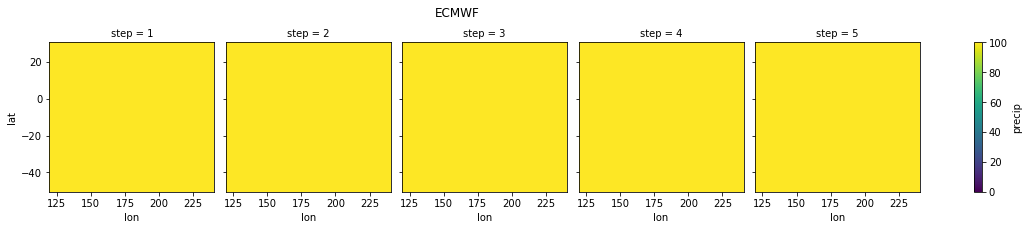

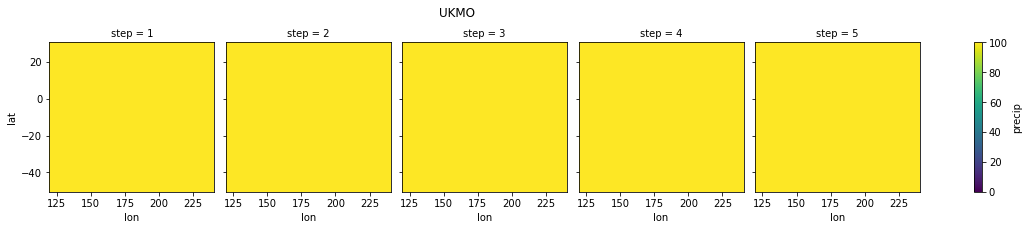

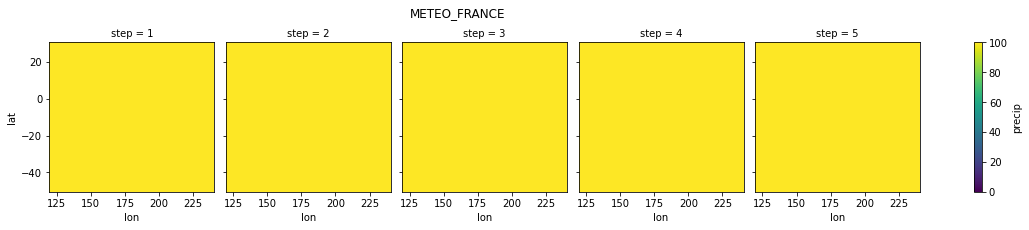

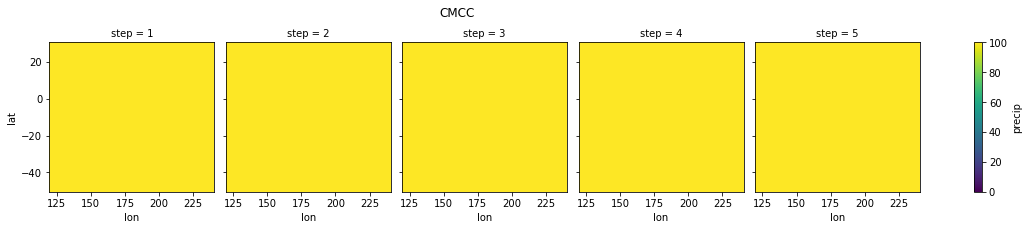

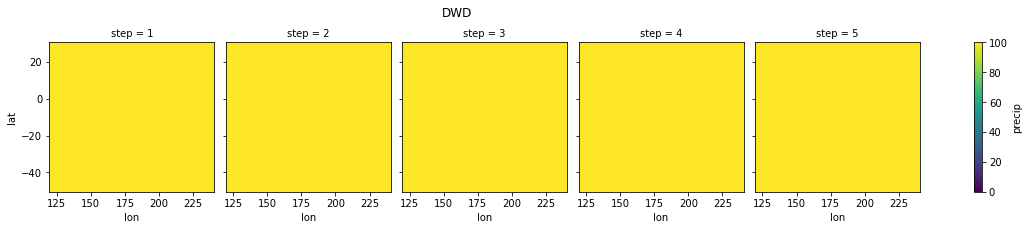

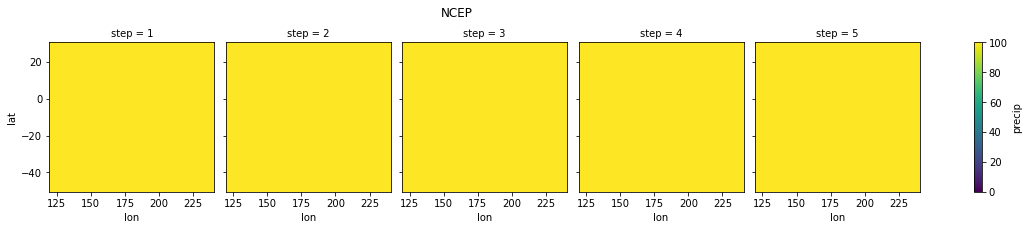

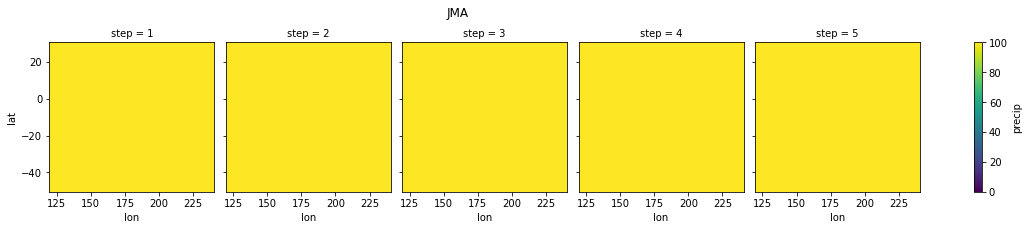

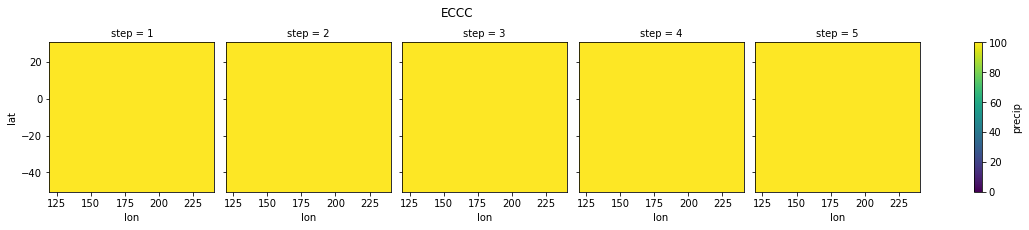

In [25]:
for GCM in list_GCMs:
    fg = probs.sel(GCM=GCM).sum(quantile).squeeze()[varname].plot(col='step', vmin=0);
    fg.fig.suptitle(GCM, x=0.4, horizontalalignment='center',y=1.05)

### calculates the average across the GCM dimension 

In [26]:
probs_mean = probs.mean('GCM')

### saves to disk ?

In [27]:
probs_mean.to_netcdf('./prob_mean.nc')

### because of numerical approximations, this average can **SOMETIMES** sum to slightly over 100 (the errors can accumulate over all the dimensions)

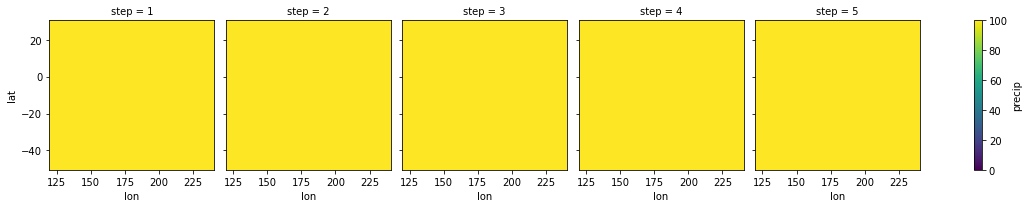

In [28]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### so we rescale (just in case)

In [29]:
probs_mean = (probs_mean / probs_mean.sum(quantile)) * 100

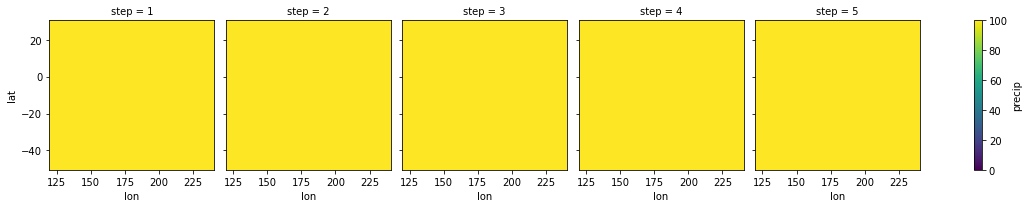

In [30]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### because the attributes are lost during these operations, we add them back 

In [31]:
probs_mean.attrs = probs.attrs

### Probability for being below a given percentile

#### choose the percentile here 

In [32]:
pmax = 25

### get the percentile bins edges, and select the category (starting at 1) that corresponds to the bin with right edge at `pmax`

In [33]:
print(" | ".join(map(str, probs_mean.attrs['pct_values'].tolist()))) 

0.02 | 0.05 | 0.1 | 0.15 | 0.2 | 0.25 | 0.3 | 0.35 | 0.4 | 0.45 | 0.5 | 0.55 | 0.6 | 0.65 | 0.7 | 0.75 | 0.8 | 0.85 | 0.9 | 0.95


In [34]:
max_cat = np.digitize(pmax/100, probs_mean.attrs['pct_values'])

In [35]:
max_cat

6

### plots the probabilities 

In [36]:
cmap = palettable.scientific.sequential.Bilbao_20.mpl_colormap

In [37]:
domain = domains.domains['Water_Watch']

### quick plot 

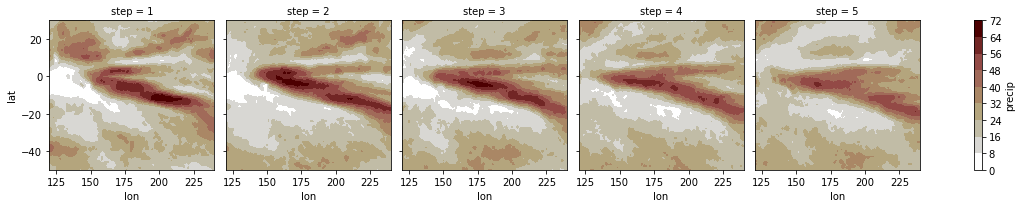

In [38]:
_ = probs_mean.sel({quantile:slice(None, max_cat)}).sum(quantile)[varname].squeeze().plot.contourf(col='step', levels=10, cmap=cmap)

### plot the probabilities for rainfall being below the climatological 25th percentile, for the next 3 months period  

In [39]:
probs_mean

<xarray.Dataset>
Dimensions:     (time: 1, lon: 121, lat: 81, step: 5, percentile: 21)
Coordinates:
  * time        (time) datetime64[ns] 2021-08-01
  * lon         (lon) float32 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * lat         (lat) float32 -50.0 -49.0 -48.0 -47.0 ... 27.0 28.0 29.0 30.0
  * step        (step) int64 1 2 3 4 5
    month       int64 8
  * percentile  (percentile) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21
Data variables:
    precip      (percentile, time, step, lat, lon) float64 dask.array<chunksize=(21, 1, 5, 81, 121), meta=np.ndarray>
Attributes:
    pct_values:  [0.02 0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55...

In [44]:
pct = pmax

In [45]:
month = probs_mean.time.to_index().month[0]
year = probs_mean.time.to_index().year[0]

# get the percentile bins  

percentile_bins = probs_mean.attrs['pct_values']

# digitize, so we can get the corresponding category along the tercile, decile or percentile dimension 

max_cat = np.digitize(pct / 100, percentile_bins)

In [46]:
max_cat

6

In [47]:
comp='below'

In [49]:
pct_dim = 'percentile'

In [50]:
if comp == 'above': 

    ptot = probs_mean.sel({pct_dim:slice(max_cat+1, None)}).sum(pct_dim)

elif comp == 'below':  

    ptot = probs_mean.sel({pct_dim:slice(None, max_cat)}).sum(pct_dim)

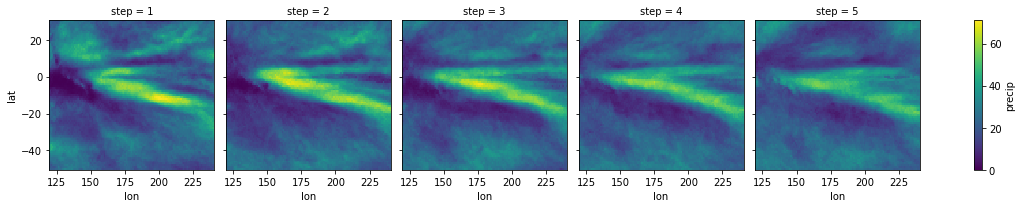

In [52]:
ptot.squeeze()['precip'].plot(col='step')

In [53]:
    dops = {}
    dops['below'] = '<'
    dops['above'] = '>'

In [54]:
max_prob = float(ptot.max(['step','lat','lon']).squeeze()[varname].data)

In [55]:
max_prob

71.02832919768402

In [56]:
nsteps

5

In [57]:
steps = probs_mean['step'].data

In [58]:
steps

array([1, 2, 3, 4, 5])

In [61]:
contours_l = [(int(max_prob * 0.80) // 10 * 10) -10,  int(max_prob * 0.80) // 10 * 10]

In [62]:
contours_l

[40, 50]

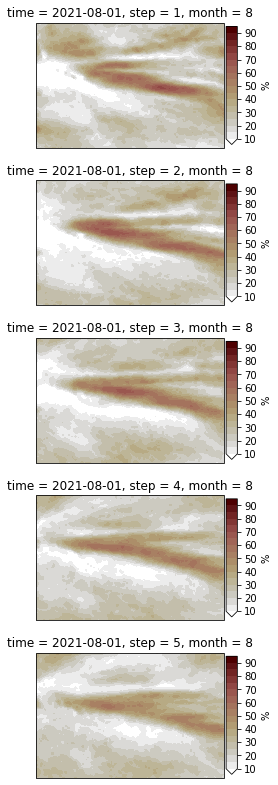

In [60]:
f, axes = plt.subplots(nrows=nsteps, figsize=(4,14), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)})

for i, step in enumerate(steps[:nsteps]): 

    ax = axes[i]

    p = ptot.sel({'step':step})[varname].squeeze()
    
    ff = p.plot.contourf(ax=ax, x='lon',y='lat', levels=np.arange(10,100,5), add_colorbar=True, transform=ccrs.PlateCarree(), \
                             cbar_kwargs={'shrink':0.9, 'label':'%', 'aspect':10, 'pad':0.01, 'extend':'neither'}, cmap=cmap)
    
    

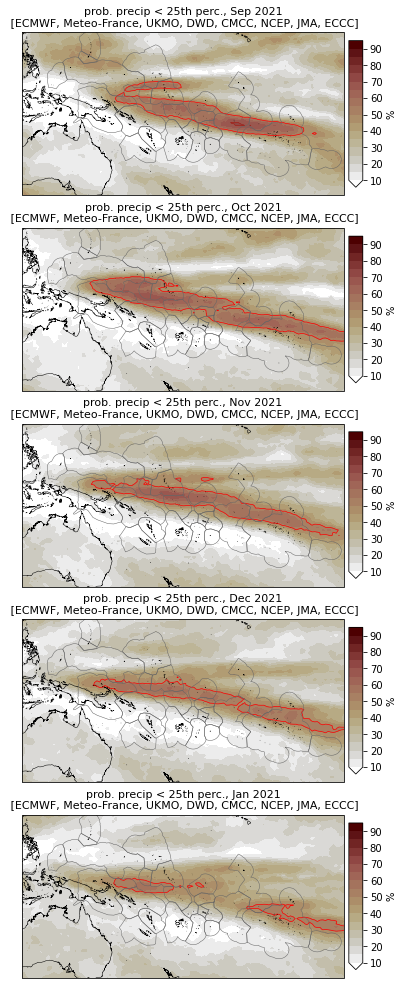

In [75]:
f = plot.map_MME_probabilities(probs_mean, nsteps=nsteps, pct=pmax, domain=domain, shape=EEZs, pct_dim=quantile)

In [76]:
f.savefig(f'./prob_map_{period}.png', dpi=200, bbox_inches='tight')

### probability for rainfall accumulation being below the median (50th percentile), for the next 5 months period

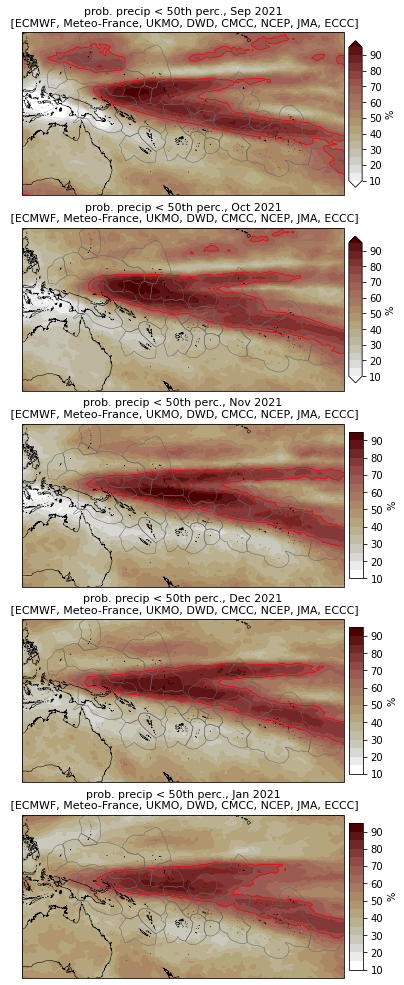

In [77]:
f = plot.map_MME_probabilities(probs_mean, nsteps=nsteps, pct=50, domain=domain, shape=EEZs, pct_dim=quantile, contours=[70, 80])

In [78]:
f.savefig(f'./prob_map_median_{period}.png', dpi=200, bbox_inches='tight')

### probability for rainfall accumulation being above the median (50th percentile)

In [79]:
import palettable

In [80]:
cmap = palettable.scientific.diverging.Roma_20.mpl_colormap

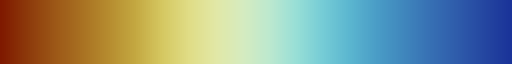

In [81]:
cmap

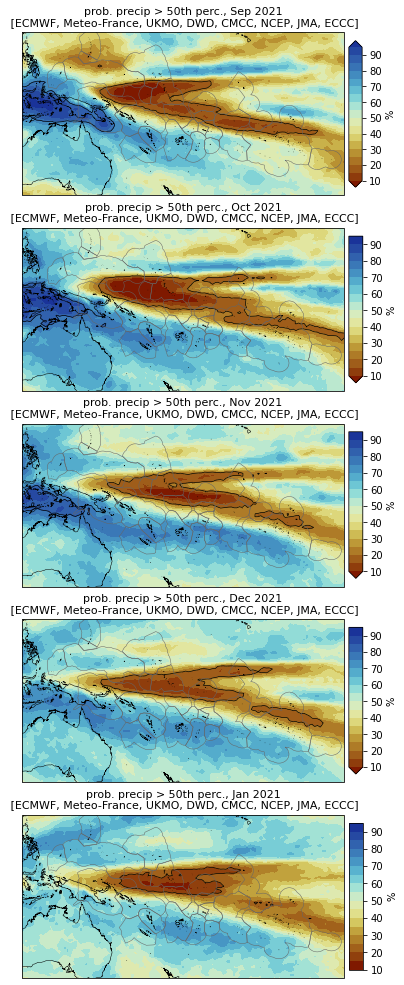

In [82]:
f = plot.map_MME_probabilities(probs_mean, nsteps=nsteps, pct=50, comp='above', domain=domain, shape=EEZs, pct_dim=quantile, contours=[20, 80],  contours_colors=['k', 'k'], cmap=cmap)

In [83]:
f.savefig(f'./prob_map_median_above_{period}.png', dpi=200, bbox_inches='tight')

### probability for rainfall accumulation being above the 70th percentile

#### note that if the contours passed to the function are over the maximum, some defaults are used 

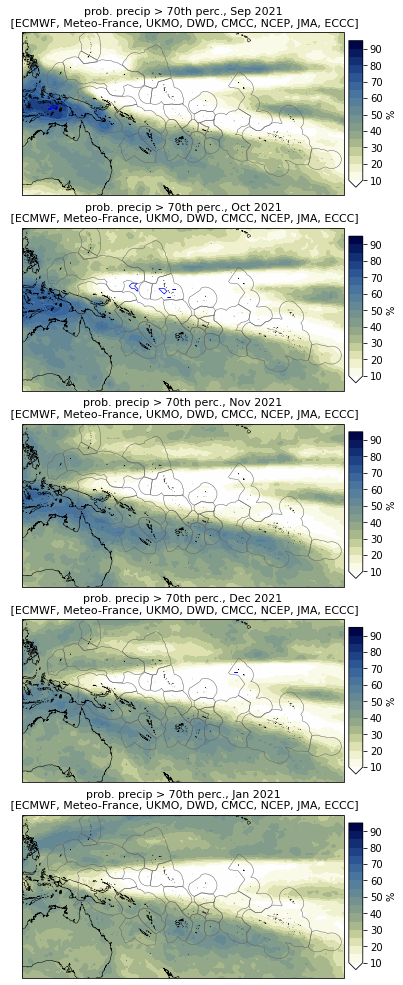

In [84]:
f = plot.map_MME_probabilities(probs_mean, nsteps=nsteps, pct=70, comp='above', domain=domain, shape=EEZs, contours=[70, 80], contours_colors=['steelblue', 'b'])

In [85]:
f.savefig(f'./prob_map_70_above_{period}.png', dpi=200, bbox_inches='tight')

### we can also insert a mask (from a geopandas dataframe) and apply it

<AxesSubplot:>

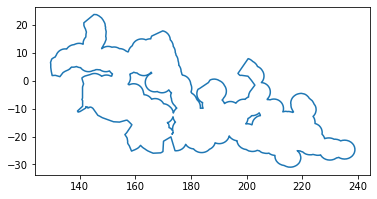

In [86]:
merged_EEZs.boundary.plot()

In [87]:
probs_mean_masked  = geo.make_mask_from_gpd(probs_mean, merged_EEZs, insert=True, mask_name='mask')

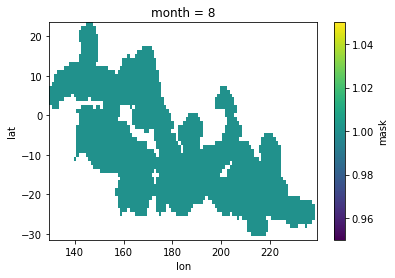

In [88]:
probs_mean_masked['mask'].plot()

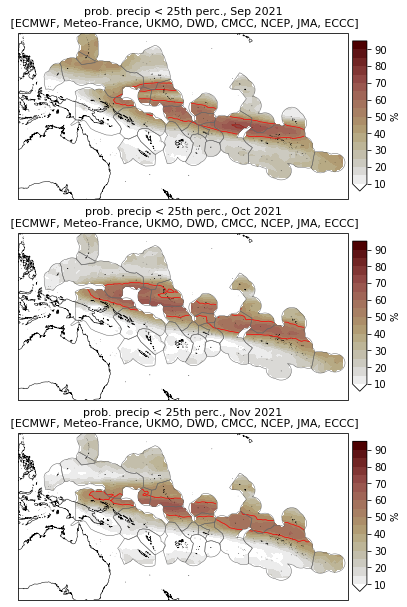

In [89]:
f = plot.map_MME_probabilities(probs_mean_masked, nsteps=3, pct=pmax, shape=EEZs, domain=domain, pct_dim=quantile, mask='mask')